**TASK 1: Exploratory Data Analysis (EDA) and Business Insights**

In [3]:
#importing libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fpdf import FPDF
import warnings
warnings.filterwarnings('ignore')
sns.set_palette("husl")

In [4]:
## Performing EDA Analysis here:

class ECommerceAnalyzer:
    def __init__(self, customers_path, products_path, transactions_path):
        """Initialize the analyzer with data paths"""
        self.load_data(customers_path, products_path, transactions_path)
        self.preprocess_data()

    def load_data(self, customers_path, products_path, transactions_path):
        """Load and store the datasets"""
        self.customers = pd.read_csv(customers_path)
        self.products = pd.read_csv(products_path)
        self.transactions = pd.read_csv(transactions_path)

    def preprocess_data(self):
        """Perform data preprocessing"""
        # Convert dates
        self.customers['SignupDate'] = pd.to_datetime(self.customers['SignupDate'])
        self.transactions['TransactionDate'] = pd.to_datetime(self.transactions['TransactionDate'])

        # Create merged dataset
        self.merged_data = self.transactions.merge(
            self.customers, on='CustomerID'
        ).merge(
            self.products, on='ProductID'
        )

        # Add derived columns
        self.merged_data['Month'] = self.merged_data['TransactionDate'].dt.month
        self.merged_data['DayOfWeek'] = self.merged_data['TransactionDate'].dt.day_name()
        self.merged_data['Hour'] = self.merged_data['TransactionDate'].dt.hour

    def customer_analysis(self):
        """Analyze customer behavior and patterns"""
        # Customer acquisition over time
        monthly_signups = self.customers.groupby(
            self.customers['SignupDate'].dt.to_period('M')
        ).size()

        # Customer value analysis
        customer_value = self.merged_data.groupby('CustomerID').agg({
            'TransactionID': 'count',
            'TotalValue': 'sum',
            'Quantity': 'sum'
        }).rename(columns={
            'TransactionID': 'Total_Transactions',
            'TotalValue': 'Total_Spend',
            'Quantity': 'Total_Items'
        })

        # Regional distribution
        regional_stats = self.merged_data.groupby('Region').agg({
            'TotalValue': 'sum',
            'TransactionID': 'count',
            'CustomerID': 'nunique'
        }).round(2)

        return monthly_signups, customer_value, regional_stats

    def product_analysis(self):
        """Analyze product performance and categories"""
        # Category performance
        category_performance = self.merged_data.groupby('Category').agg({
            'TotalValue': 'sum',
            'Quantity': 'sum',
            'TransactionID': 'count'
        }).round(2)

        # Product popularity
        product_popularity = self.merged_data.groupby('ProductName').agg({
            'Quantity': 'sum',
            'TotalValue': 'sum'
        }).sort_values('Quantity', ascending=False)

        # Price distribution by category
        price_distribution = self.products.groupby('Category')['Price'].agg([
            'mean', 'median', 'std', 'min', 'max'
        ]).round(2)

        return category_performance, product_popularity, price_distribution

    def temporal_analysis(self):
        """Analyze temporal patterns in transactions"""
        # Daily patterns
        hourly_transactions = self.merged_data.groupby('Hour')['TotalValue'].sum()
        daily_transactions = self.merged_data.groupby('DayOfWeek')['TotalValue'].sum()

        # Monthly trends
        monthly_trends = self.merged_data.groupby('Month').agg({
            'TotalValue': 'sum',
            'Quantity': 'mean',
            'TransactionID': 'count'
        })

        return hourly_transactions, daily_transactions, monthly_trends

    def create_visualizations(self):
        """Generate comprehensive visualizations"""
        # Create subplots
        fig = plt.figure(figsize=(20, 25))

        # 1. Regional Analysis
        plt.subplot(421)
        sns.barplot(
            data=self.merged_data,
            x='Region',
            y='TotalValue',
            estimator='sum',
            ci=None
        )
        plt.title('Revenue by Region', fontsize=12)
        plt.xticks(rotation=45)

        # 2. Category Performance
        plt.subplot(422)
        category_sales = self.merged_data.groupby('Category')['TotalValue'].sum()
        category_sales.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Sales Distribution by Category', fontsize=12)

        # 3. Customer Acquisition Trend
        plt.subplot(423)
        monthly_signups = self.customers.groupby(
            self.customers['SignupDate'].dt.to_period('M')
        ).size()
        monthly_signups.plot(kind='line', marker='o')
        plt.title('Customer Acquisition Trend', fontsize=12)
        plt.xticks(rotation=45)

        # 4. Price Distribution
        plt.subplot(424)
        sns.boxplot(data=self.products, x='Category', y='Price')
        plt.title('Price Distribution by Category', fontsize=12)
        plt.xticks(rotation=45)

        # 5. Hour of Day Analysis
        plt.subplot(425)
        hourly_sales = self.merged_data.groupby('Hour')['TotalValue'].sum()
        hourly_sales.plot(kind='line', marker='o')
        plt.title('Sales by Hour of Day', fontsize=12)

        # 6. Top Products
        plt.subplot(426)
        top_products = self.merged_data.groupby('ProductName')['Quantity'].sum().nlargest(10)
        top_products.plot(kind='barh')
        plt.title('Top 10 Products by Quantity Sold', fontsize=12)

        # 7. Customer Value Distribution
        plt.subplot(427)
        customer_value = self.merged_data.groupby('CustomerID')['TotalValue'].sum()
        sns.histplot(customer_value, bins=30)
        plt.title('Customer Value Distribution', fontsize=12)

        # 8. Daily Pattern
        plt.subplot(428)
        daily_sales = self.merged_data.groupby('DayOfWeek')['TotalValue'].sum()
        daily_sales.plot(kind='bar')
        plt.title('Sales by Day of Week', fontsize=12)
        plt.xticks(rotation=45)

        plt.tight_layout()
        return fig

    def generate_insights(self):
        """Generate key business insights"""
        # Calculate key metrics
        total_revenue = self.merged_data['TotalValue'].sum()
        avg_order_value = self.merged_data.groupby('TransactionID')['TotalValue'].mean()
        customer_lifetime_value = self.merged_data.groupby('CustomerID')['TotalValue'].sum().mean()

        insights = [
            f"Regional Performance: {self.merged_data.groupby('Region')['TotalValue'].sum().idxmax()} "
            f"leads in revenue generation with {(self.merged_data.groupby('Region')['TotalValue'].sum().max()/total_revenue*100):.1f}% "
            f"of total sales, suggesting strong market presence and potential for expansion in this region.",

            f"Product Category Success: {self.merged_data.groupby('Category')['TotalValue'].sum().idxmax()} "
            f"category shows highest profitability with average transaction value of "
            f"${self.merged_data[self.merged_data['Category']==self.merged_data.groupby('Category')['TotalValue'].sum().idxmax()]['TotalValue'].mean():.2f}, "
            f"indicating strong customer preference and pricing strategy effectiveness.",

            f"Customer Behavior: Average order value is ${avg_order_value.mean():.2f} with "
            f"customer lifetime value of ${customer_lifetime_value:.2f}. Top 20% of customers contribute "
            f"{(self.merged_data.groupby('CustomerID')['TotalValue'].sum().nlargest(int(len(self.customers)*0.2)).sum()/total_revenue*100):.1f}% "
            f"of revenue, suggesting opportunity for loyalty program enhancement.",

            f"Temporal Patterns: Peak shopping hours are between "
            f"{self.merged_data.groupby('Hour')['TotalValue'].sum().nlargest(3).index.tolist()} "
            f"with {self.merged_data.groupby('DayOfWeek')['TotalValue'].sum().idxmax()} "
            f"being the busiest day, crucial for resource allocation and promotional timing.",

            f"Product Performance: Top 3 products account for "
            f"{(self.merged_data.groupby('ProductID')['Quantity'].sum().nlargest(3).sum()/self.merged_data['Quantity'].sum()*100):.1f}% "
            f"of total units sold, while {len(self.merged_data[self.merged_data['Quantity']==1]['ProductID'].unique())} "
            f"products show single-unit sales, indicating need for inventory optimization."
        ]

        return insights



In [5]:
# Creating PDF Report
class BusinessReport(FPDF):
    def __init__(self):
        super().__init__()
        self.set_auto_page_break(auto=True, margin=15)

    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'E-Commerce Business Intelligence Report', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 11)
        self.multi_cell(0, 10, body)
        self.ln()


Analysis completed successfully!
PDF report generated as 'Shrinath_Asati_EDA.pdf'


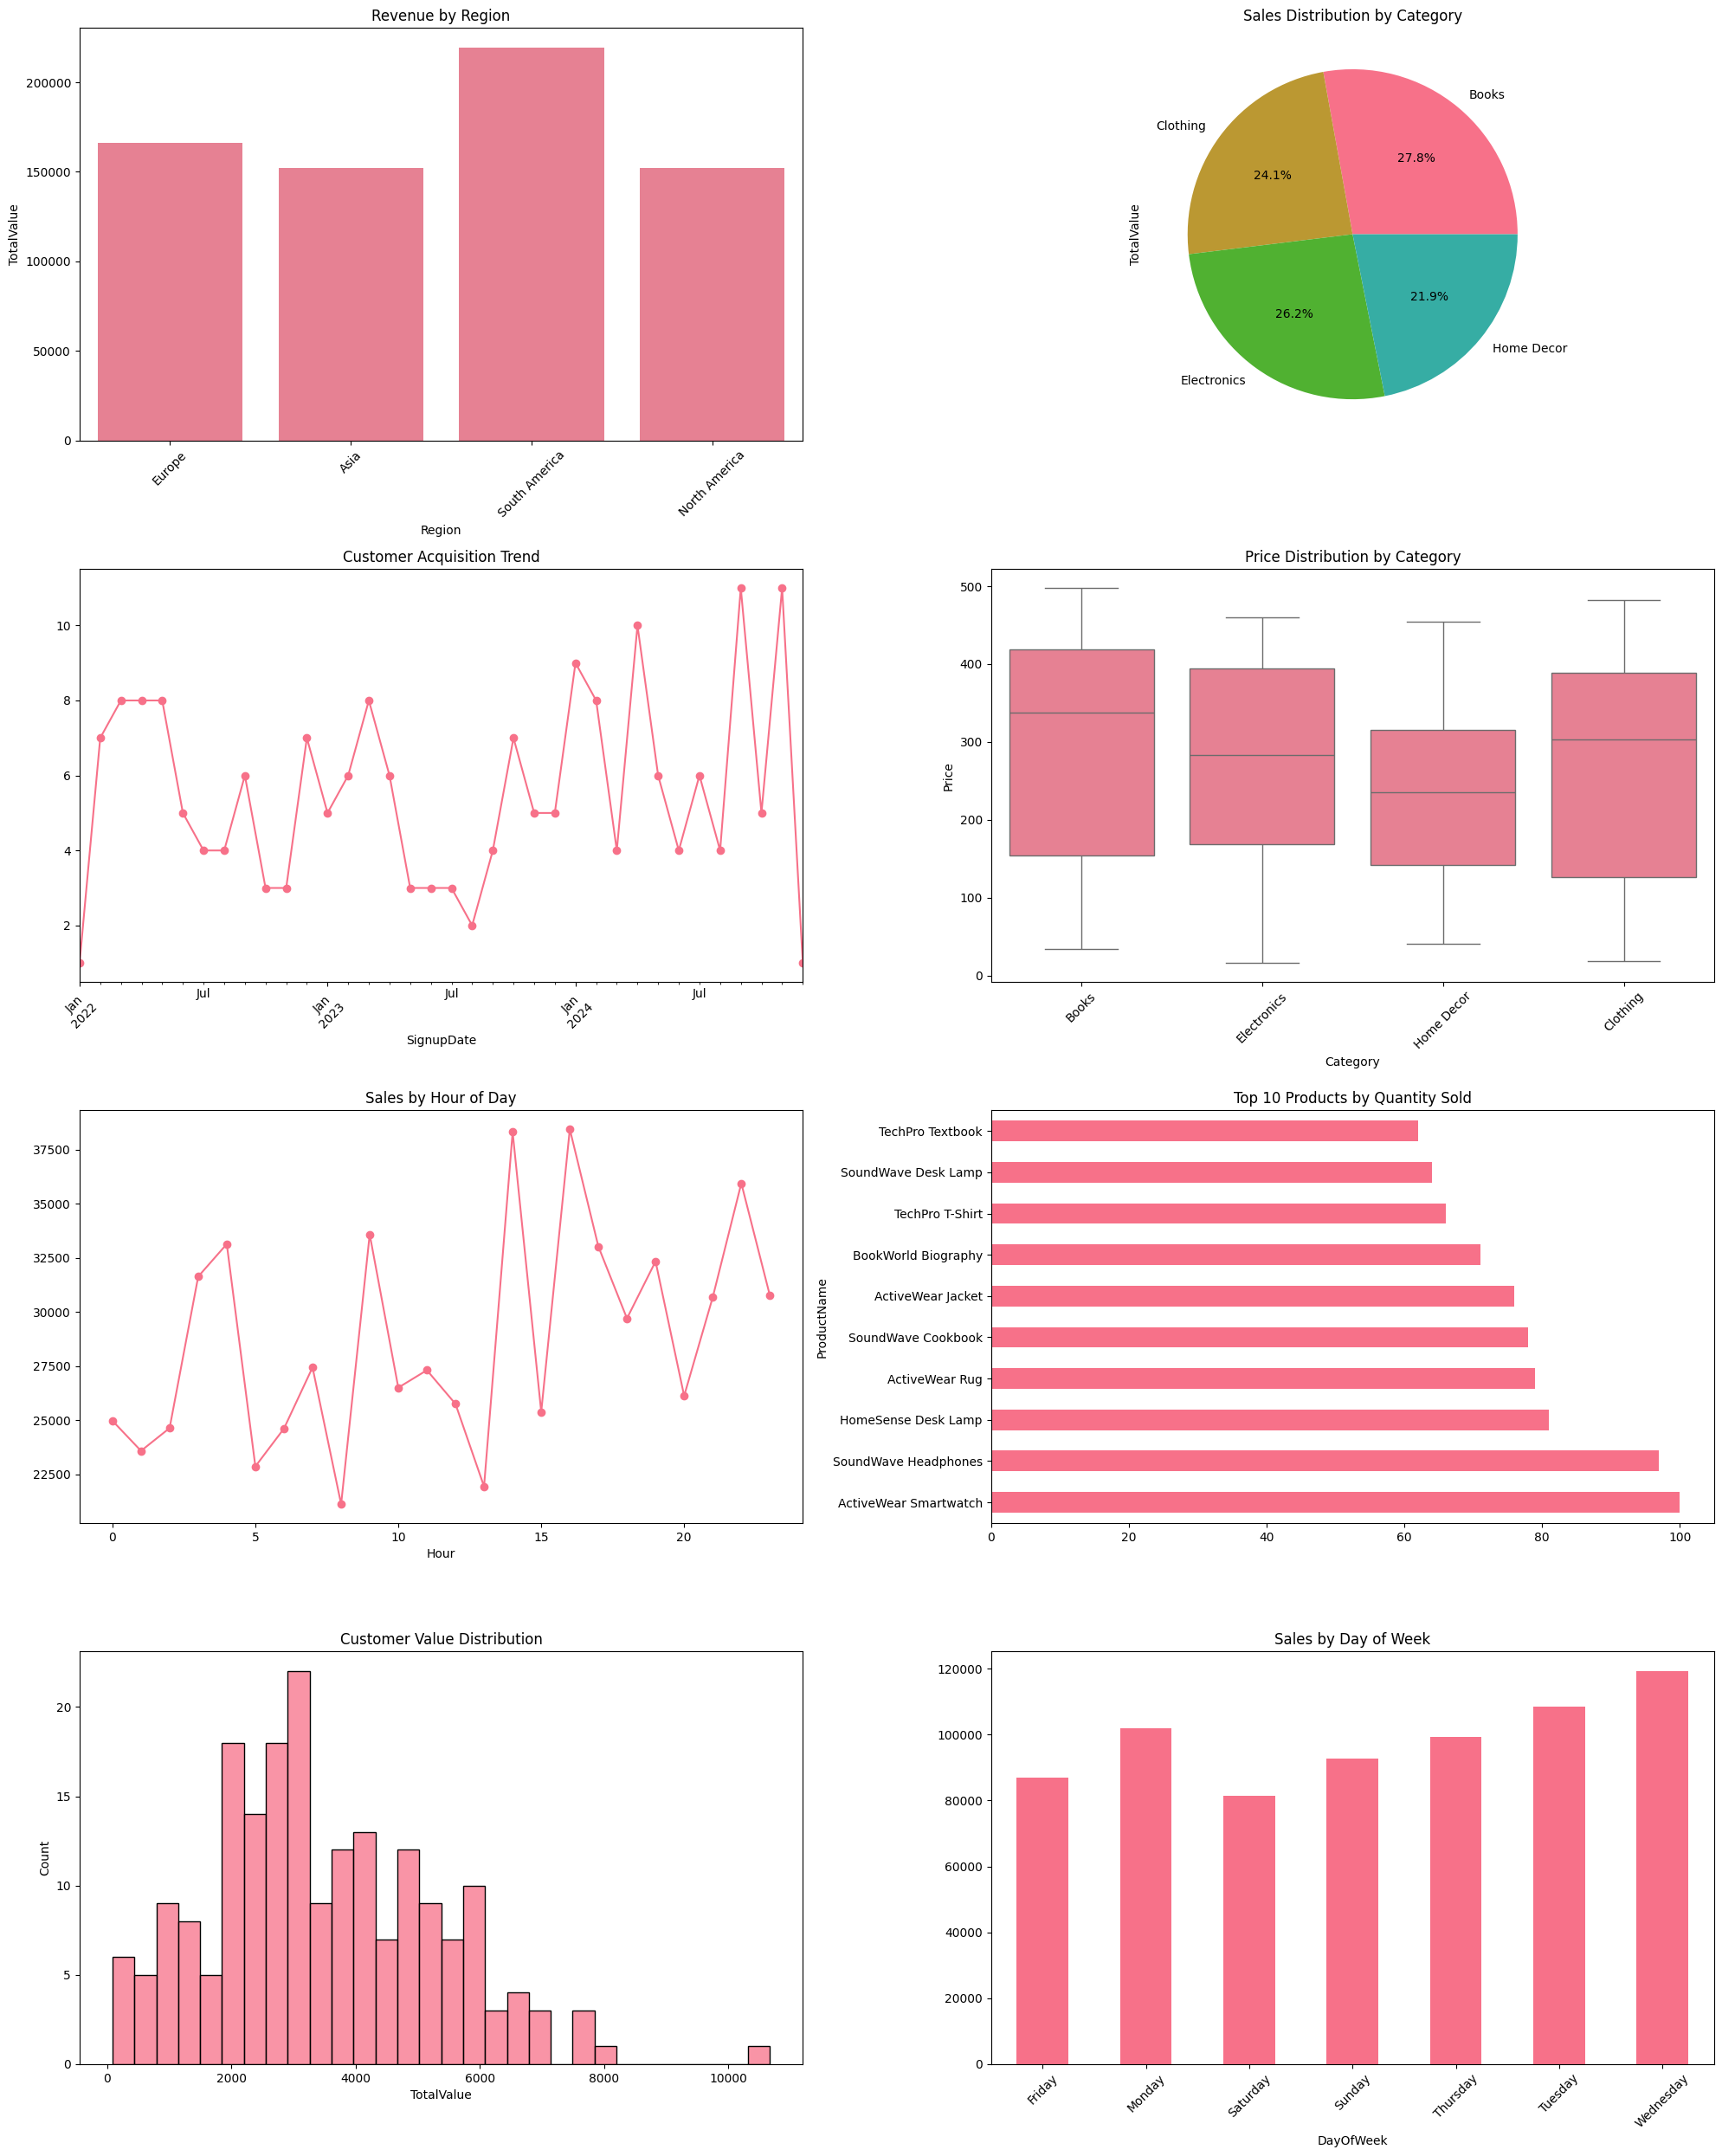

In [6]:
# Main function:
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = ECommerceAnalyzer('Customers.csv', 'Products.csv', 'Transactions.csv')

    # Generate analyses
    customer_analysis = analyzer.customer_analysis()
    product_analysis = analyzer.product_analysis()
    temporal_analysis = analyzer.temporal_analysis()

    # Create visualizations
    fig = analyzer.create_visualizations()
    plt.savefig('EDA_Visualizations.png')

    # Generate insights
    insights = analyzer.generate_insights()

    # Create PDF report
    report = BusinessReport()
    report.add_page()
    report.chapter_title('Key Business Insights')
    for i, insight in enumerate(insights, 1):
        report.chapter_body(f"{i}. {insight}")
    report.add_page()
    report.chapter_title('Data Visualizations')
    report.image('EDA_Visualizations.png', x=10, w=190)
    report.output('Shrinath_Asati_EDA.pdf')

    print("Analysis completed successfully!")
    print("PDF report generated as 'Shrinath_Asati_EDA.pdf'")